# By : Lokendra Carpenter_200240128014

In [1]:
# Setup
import os
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from google.colab.patches import cv2_imshow

ModuleNotFoundError: No module named 'google.colab'

In [2]:
# mount google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# go to the directory where data folder is stored
os.chdir('./drive/My Drive/Colab Notebooks/Data/')

In [4]:
# XML parsing
def get_info(file):
    xmlFile=ET.parse(file)
    root=xmlFile.getroot()
    file_name=root.find('filename').text
    no_obj=0
    name=[]
    cords=[]

    for obj in root.findall('object'):
        no_obj+=1
        name.append(obj.find('name').text)
        xmin=obj.find('bndbox')[0].text
        ymin=obj.find('bndbox')[1].text    
        xmax=obj.find('bndbox')[2].text    
        ymax=obj.find('bndbox')[3].text
        cords.append([xmin,ymin,xmax,ymax])
    return(file_name,no_obj,name,cords)

In [5]:
# list of XML files
file_list=os.listdir('./annotations')

In [6]:
# Create a Dataframe of image file name,no of persons in that image, labels attached to them and coordintes of faces
file_names=[]
no_objects=[]
tag_list=[]
coordinates=[]
for file in file_list:
  f,n_o,tags,cords=get_info('./annotations/'+str(file))
  file_names.append(f)
  no_objects.append(n_o)
  tag_list.append(tags)
  coordinates.append(cords)

df=pd.DataFrame({'file_name':file_names,'no_object':no_objects,'tags':tag_list,'coordinates':coordinates})

In [7]:
df

,file_name,no_object,tags,coordinates
0,maksssksksss103.png,4,"[with_mask, with_mask, with_mask, with_mask]","[[42, 54, 94, 110], [188, 46, 236, 106], [261,..."
1,maksssksksss104.png,8,"[without_mask, without_mask, without_mask, wit...","[[42, 109, 66, 140], [2, 105, 22, 125], [30, 8..."
2,maksssksksss0.png,3,"[without_mask, with_mask, without_mask]","[[79, 105, 109, 142], [185, 100, 226, 144], [3..."
3,maksssksksss109.png,1,[with_mask],"[[216, 92, 372, 251]]"
4,maksssksksss100.png,3,"[with_mask, with_mask, with_mask]","[[189, 30, 245, 88], [387, 54, 400, 75], [118,..."
...,...,...,...,...
848,maksssksksss235.png,4,"[with_mask, with_mask, with_mask, with_mask]","[[310, 80, 342, 116], [221, 104, 231, 119], [2..."
849,maksssksksss255.png,19,"[with_mask, with_mask, with_mask, with_mask, w...","[[1, 77, 8, 83], [43, 82, 51, 89], [7, 95, 22,..."
850,maksssksksss185.png,4,"[with_mask, with_mask, with_mask, with_mask]","[[89, 139, 121, 187], [115, 112, 139, 154], [1..."
851,maksssksksss431.png,13,"[mask_weared_incorrect, with_mask, with_mask, ...","[[20, 71, 76, 129], [150, 114, 197, 171], [201..."


In [8]:
# split data into train and test
train_df=df.loc[:650,:]
test_df=df.loc[650:,:]

In [9]:
# A Data frame having only faces and labels
image_list=[]
tag_list=[]

for f in train_df.loc[:,'file_name']:
  img=cv2.imread('./images/'+str(f))
  tags=train_df.loc[df.file_name==f,'tags'].values
  coordinates=train_df.loc[df.file_name==f,'coordinates'].values

  for i in range(len(tags[0])):

    coordinate=coordinates[0][i]
    
    xmin=int(coordinate[0])
    ymin=int(coordinate[1])
    xmax=int(coordinate[2])
    ymax=int(coordinate[3])

    image=img[ymin:ymax,xmin:xmax]
    image=cv2.resize(image,(28,28))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    tag=tags[0][i]
    image_list.append(image)
    tag_list.append(tag)

faces_df=pd.DataFrame({'img':image_list,'tags':tag_list})


In [10]:
print(len(faces_df))
faces_df.head()

3066


,img,tags
0,"[[77, 75, 71, 76, 86, 90, 86, 85, 82, 80, 85, ...",with_mask
1,"[[197, 197, 190, 195, 213, 207, 193, 196, 197,...",with_mask
2,"[[45, 47, 87, 147, 154, 164, 176, 188, 183, 16...",with_mask
3,"[[10, 7, 14, 56, 103, 117, 125, 135, 142, 149,...",with_mask
4,"[[21, 50, 104, 137, 148, 154, 154, 154, 157, 1...",without_mask


In [ ]:
# sample of face
img=faces_df.loc[2,'img']
print(img.shape)
print(faces_df.loc[2,'tags'])
cv2_imshow(img)

In [12]:
# Flatten and normalize all images
def flat(img):
  img=img/255
  return(img.flatten())
faces_df['img']=faces_df.img.apply(flat)

In [13]:
faces_df.head()

,img,tags
0,"[0.30196078431372547, 0.29411764705882354, 0.2...",with_mask
1,"[0.7725490196078432, 0.7725490196078432, 0.745...",with_mask
2,"[0.17647058823529413, 0.1843137254901961, 0.34...",with_mask
3,"[0.0392156862745098, 0.027450980392156862, 0.0...",with_mask
4,"[0.08235294117647059, 0.19607843137254902, 0.4...",without_mask


In [14]:
# create columns with values of each pixel from the image
final_df=pd.DataFrame(index=range(len(faces_df)),columns=range(785))

for i in range(len(faces_df)):
  final_df.iloc[i,0]=faces_df.tags[i]
  for j in range(1,785):
    final_df.iloc[i,j]=faces_df.img[i][j-1]

In [15]:
final_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,with_mask,0.301961,0.294118,0.278431,0.298039,0.337255,0.352941,0.337255,0.333333,0.321569,0.313725,0.333333,0.337255,0.368627,0.372549,0.403922,0.458824,0.478431,0.466667,0.439216,0.439216,0.443137,0.462745,0.47451,0.517647,0.513725,0.258824,0.352941,0.72549,0.207843,0.211765,0.231373,0.294118,0.368627,0.392157,0.34902,0.313725,0.298039,0.329412,0.341176,...,0.0196078,0.0196078,0.0156863,0.027451,0.141176,0.282353,0.290196,0.282353,0.278431,0.258824,0.258824,0.258824,0.670588,0.615686,0.556863,0.341176,0.192157,0.223529,0.219608,0.207843,0.196078,0.184314,0.117647,0.054902,0.0431373,0.0470588,0.0470588,0.0392157,0.0862745,0.0862745,0.145098,0.0705882,0.235294,0.321569,0.337255,0.329412,0.321569,0.301961,0.301961,0.294118
1,with_mask,0.772549,0.772549,0.745098,0.764706,0.835294,0.811765,0.756863,0.768627,0.772549,0.772549,0.745098,0.721569,0.654902,0.576471,0.533333,0.498039,0.45098,0.423529,0.396078,0.403922,0.403922,0.411765,0.501961,0.756863,0.780392,0.756863,0.756863,0.756863,0.772549,0.670588,0.67451,0.764706,0.776471,0.760784,0.721569,0.690196,0.733333,0.690196,0.521569,...,0.427451,0.431373,0.443137,0.482353,0.529412,0.678431,0.729412,0.729412,0.713725,0.682353,0.666667,0.713725,0.611765,0.666667,0.592157,0.47451,0.447059,0.4,0.294118,0.25098,0.239216,0.25098,0.254902,0.254902,0.298039,0.368627,0.392157,0.403922,0.396078,0.388235,0.360784,0.345098,0.647059,0.701961,0.678431,0.65098,0.67451,0.709804,0.721569,0.729412
2,with_mask,0.176471,0.184314,0.341176,0.576471,0.603922,0.643137,0.690196,0.737255,0.717647,0.643137,0.584314,0.564706,0.552941,0.556863,0.545098,0.521569,0.498039,0.466667,0.439216,0.407843,0.384314,0.372549,0.313725,0.235294,0.117647,0.129412,0.258824,0.423529,0.25098,0.247059,0.419608,0.580392,0.615686,0.65098,0.658824,0.588235,0.490196,0.466667,0.498039,...,0.478431,0.439216,0.356863,0.278431,0.290196,0.301961,0.32549,0.360784,0.4,0.384314,0.380392,0.352941,0.678431,0.67451,0.623529,0.466667,0.364706,0.329412,0.364706,0.447059,0.494118,0.486275,0.478431,0.470588,0.462745,0.447059,0.396078,0.329412,0.27451,0.243137,0.247059,0.270588,0.301961,0.321569,0.376471,0.403922,0.45098,0.372549,0.337255,0.321569
3,with_mask,0.0392157,0.027451,0.054902,0.219608,0.403922,0.458824,0.490196,0.529412,0.556863,0.584314,0.6,0.607843,0.6,0.6,0.580392,0.537255,0.490196,0.439216,0.392157,0.356863,0.317647,0.243137,0.137255,0.0784314,0.054902,0.0431373,0.0431373,0.0392157,0.0431373,0.0313725,0.101961,0.301961,0.447059,0.482353,0.501961,0.541176,0.572549,0.592157,0.596078,...,0.607843,0.596078,0.596078,0.564706,0.478431,0.380392,0.298039,0.239216,0.207843,0.196078,0.196078,0.188235,0.458824,0.462745,0.462745,0.443137,0.411765,0.419608,0.443137,0.478431,0.517647,0.533333,0.541176,0.541176,0.529412,0.545098,0.572549,0.6,0.6,0.588235,0.576471,0.572549,0.556863,0.552941,0.533333,0.482353,0.376471,0.243137,0.14902,0.121569
4,without_mask,0.0823529,0.196078,0.407843,0.537255,0.580392,0.603922,0.603922,0.603922,0.615686,0.639216,0.666667,0.694118,0.721569,0.741176,0.760784,0.780392,0.796078,0.796078,0.784314,0.768627,0.72549,0.596078,0.556863,0.501961,0.45098,0.415686,0.388235,0.384314,0.137255,0.266667,0.431373,0.529412,0.568627,0.592157,0.592157,0.592157,0.607843,0.635294,0.666667,...,0.215686,0.227451,0.243137,0.266667,0.282353,0.301961,0.333333,0.372549,0.415686,0.454902,0.490196,0.509804,0.701961,0.67451,0.631373,0.545098,0.470588,0.462745,0.415686,0.270588,0.203922,0.152941,0.12549,0.184314,0.298039,0.258824,0.184314,0.188235,0.196078,0.215686,0.239216,0.270588,0.298039,0.337255,0.364706,0.403922,0.439216,0.470588,0.505882,0.545098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [41]:
final_df[0].value_counts()

with_mask                600
without_mask             556
mask_weared_incorrect     83
Name: 0, dtype: int64

In [17]:
# Data set is imbalanced, we will do downsampling of data by randomely removing 'with_mask' data

indexes=final_df[final_df[0]=='with_mask'].index
for i in range(2427-600):
  final_df.drop(indexes[i],axis=0,inplace=True)

In [18]:
X=final_df.iloc[:,1:]
y=final_df.iloc[:,0]

In [19]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=2020,shuffle=True)

In [20]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(867, 784) (372, 784) (867,) (372,)


In [21]:
model=SVC()

In [35]:
model.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [36]:
# predictions on X_test
y_pred=model.predict(X_test)

In [37]:
accuracy_score(y_test,y_pred)

0.803763440860215

In [25]:
# fit all data to model
model.fit(X,y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [26]:
# function for prediction bounding boxes and labels
faceCascade=cv2.CascadeClassifier('./Haar Cascade files/haarcascade_frontalface_default.xml')

def with_without_mask(img):
    imgGray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=faceCascade.detectMultiScale(imgGray,1.1,4)
        
    for (x,y,w,h) in faces:
      cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),3)
      new_img = img[y:y+h, x:x+w]
      new_img=cv2.resize(new_img,(28,28))
      new_img = flat(new_img)
      imgSeries=pd.Series({i:j for i,j in zip(range(784),new_img)})
      label=model.predict([imgSeries])

      cv2.putText(img,str(label),(x,y-10),cv2.FONT_HERSHEY_COMPLEX,.5,(0,0,200),2)
    return(img)

In [27]:
# test files which are not touched yet
test_df.file_name.values

array(['maksssksksss754.png', 'maksssksksss269.png',
       'maksssksksss321.png', 'maksssksksss638.png',
       'maksssksksss626.png', 'maksssksksss690.png',
       'maksssksksss567.png', 'maksssksksss15.png', 'maksssksksss807.png',
       'maksssksksss383.png', 'maksssksksss815.png',
       'maksssksksss714.png', 'maksssksksss731.png',
       'maksssksksss809.png', 'maksssksksss89.png', 'maksssksksss363.png',
       'maksssksksss350.png', 'maksssksksss326.png',
       'maksssksksss500.png', 'maksssksksss605.png',
       'maksssksksss161.png', 'maksssksksss313.png',
       'maksssksksss797.png', 'maksssksksss646.png',
       'maksssksksss129.png', 'maksssksksss769.png',
       'maksssksksss128.png', 'maksssksksss515.png',
       'maksssksksss602.png', 'maksssksksss12.png', 'maksssksksss389.png',
       'maksssksksss760.png', 'maksssksksss93.png', 'maksssksksss381.png',
       'maksssksksss186.png', 'maksssksksss192.png',
       'maksssksksss601.png', 'maksssksksss505.png', 'maksssksks

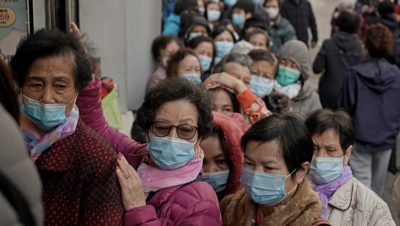

In [28]:
img=cv2.imread('./images/maksssksksss431.png')
cv2_imshow(img)

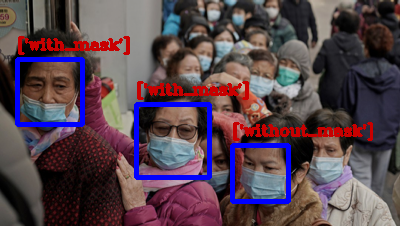

In [29]:
result=with_without_mask(img)
cv2_imshow(result)

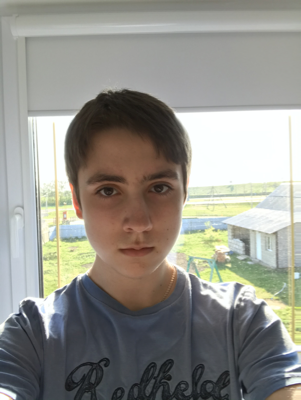

In [30]:
img=cv2.imread('./images/maksssksksss561.png')
cv2_imshow(img)

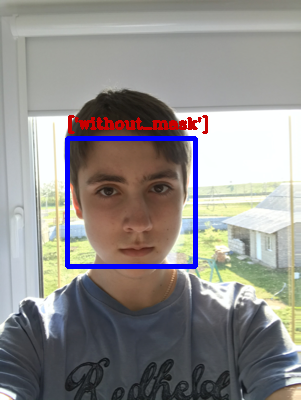

In [31]:
result=with_without_mask(img)
cv2_imshow(result)

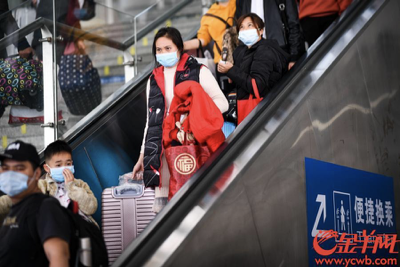

In [32]:
img=cv2.imread('./images/maksssksksss474.png')
cv2_imshow(img)

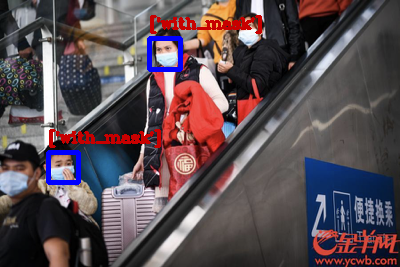

In [33]:
result=with_without_mask(img)
cv2_imshow(result)